
Analyzing with total power = 1
Total allocated power: 1.000
Achieved capacity: 6.062 bits/s/Hz


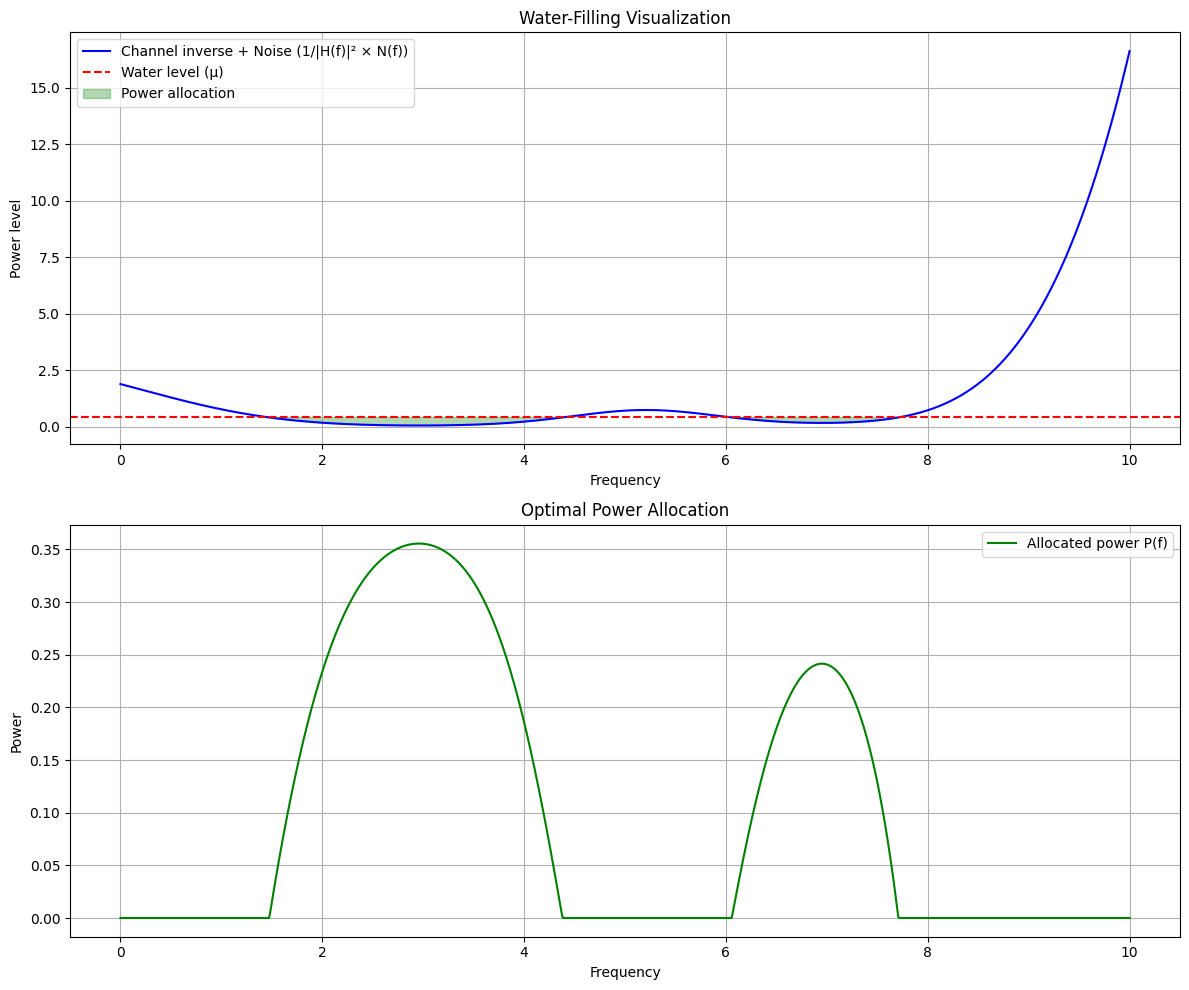


Analyzing with total power = 5
Total allocated power: 5.000
Achieved capacity: 14.228 bits/s/Hz


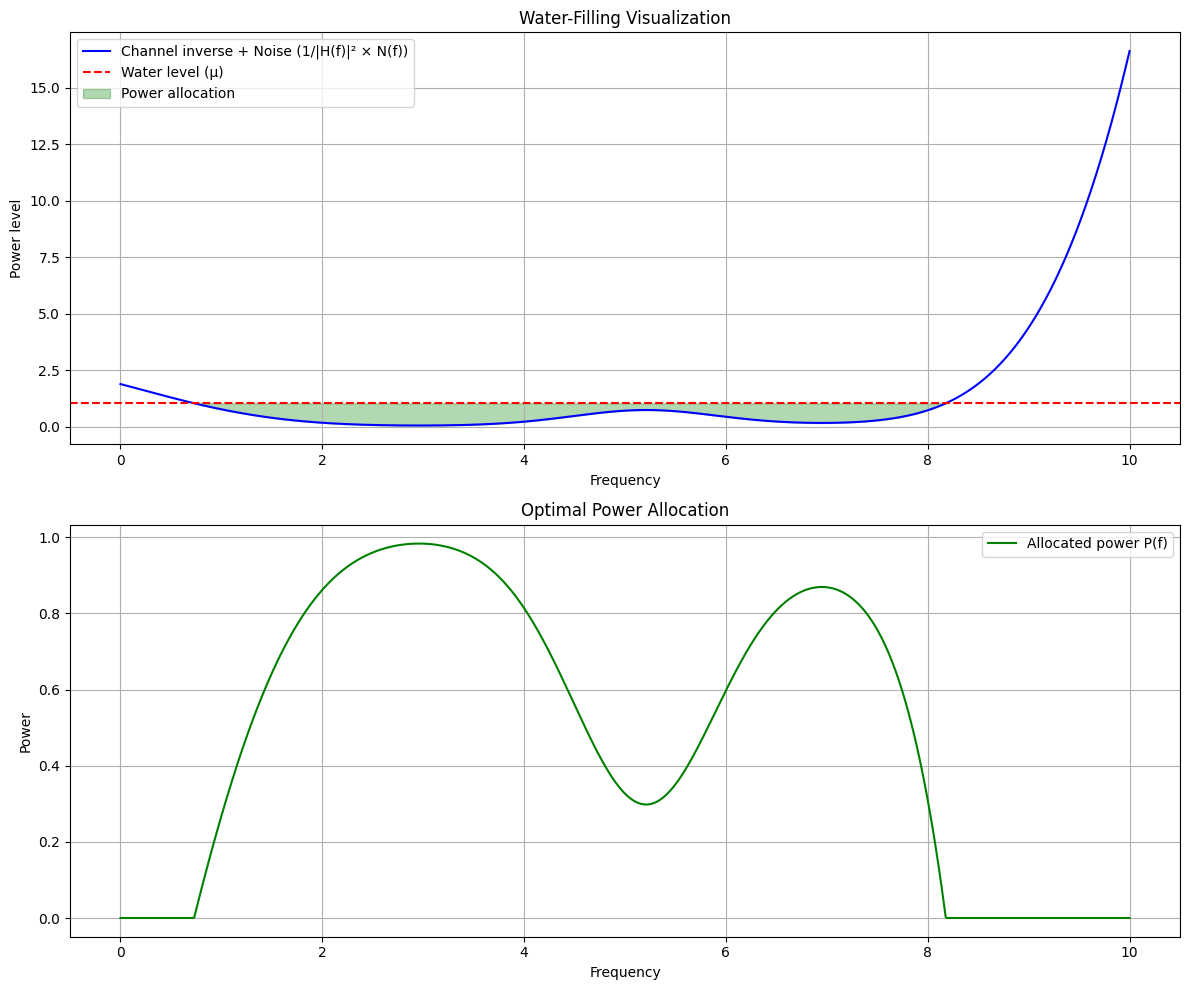


Analyzing with total power = 10
Total allocated power: 10.000
Achieved capacity: 19.615 bits/s/Hz


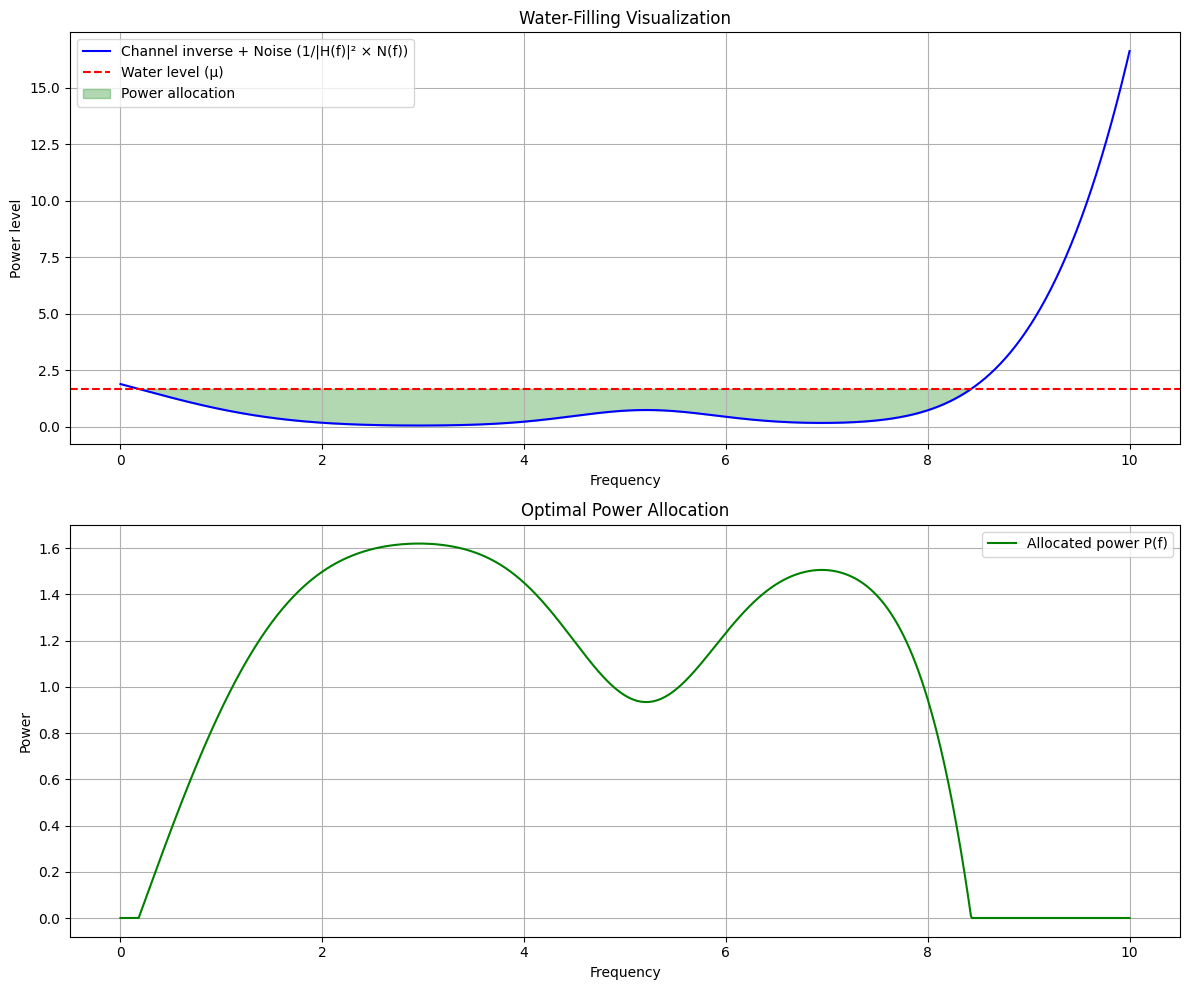

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class WaterFillingOptimizer:
    def __init__(self, freq_points=1000):
        """Initialize the water-filling optimizer."""
        self.freq_points = freq_points
        self.frequencies = np.linspace(0, 10, freq_points)

    def channel_response(self, f):
        """
        Example channel frequency response.
        This creates a frequency-selective channel with two peaks.
        """
        return 2/(1 + (f-3)**2) + 1.5/(1 + (f-7)**2)

    def noise_psd(self, f):
        """
        Noise power spectral density.
        Using colored noise for this example.
        """
        return 0.1 + 0.05*f  # Noise increases with frequency

    def find_water_level(self, total_power, tolerance=1e-6):
        """
        Find the water level (μ) that satisfies the power constraint.
        Uses binary search algorithm.
        """
        H_squared = np.array([self.channel_response(f)**2 for f in self.frequencies])
        N = np.array([self.noise_psd(f) for f in self.frequencies])

        # Initial guess for water level bounds
        mu_min = np.min(N/H_squared)
        mu_max = np.max(N/H_squared) + total_power/len(self.frequencies)*10

        while (mu_max - mu_min) > tolerance:
            mu = (mu_min + mu_max) / 2
            power = np.sum(np.maximum(0, mu - N/H_squared)) * \
                   (self.frequencies[1] - self.frequencies[0])

            if power > total_power:
                mu_max = mu
            else:
                mu_min = mu

        return mu

    def calculate_power_allocation(self, total_power):
        """
        Calculate optimal power allocation using water-filling.
        """
        # Get channel and noise characteristics
        H_squared = np.array([self.channel_response(f)**2 for f in self.frequencies])
        N = np.array([self.noise_psd(f) for f in self.frequencies])

        # Find water level
        mu = self.find_water_level(total_power)

        # Calculate power allocation
        P = np.maximum(0, mu - N/H_squared)

        return P, mu, H_squared, N

    def plot_water_filling(self, total_power):
        """
        Visualize the water-filling solution.
        """
        P, mu, H_squared, N = self.calculate_power_allocation(total_power)

        # Calculate capacity
        capacity = np.sum(np.log2(1 + P*H_squared/N)) * \
                  (self.frequencies[1] - self.frequencies[0])

        # Create visualization
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

        # Plot channel response and noise
        inverse_channel = N/H_squared
        ax1.plot(self.frequencies, inverse_channel, 'b-',
                label='Channel inverse + Noise (1/|H(f)|² × N(f))')
        ax1.axhline(y=mu, color='r', linestyle='--',
                   label='Water level (μ)')
        ax1.fill_between(self.frequencies, inverse_channel, mu,
                        where=(mu > inverse_channel), alpha=0.3,
                        color='g', label='Power allocation')
        ax1.set_title('Water-Filling Visualization')
        ax1.set_xlabel('Frequency')
        ax1.set_ylabel('Power level')
        ax1.legend()
        ax1.grid(True)

        # Plot resulting power allocation
        ax2.plot(self.frequencies, P, 'g-', label='Allocated power P(f)')
        ax2.set_title('Optimal Power Allocation')
        ax2.set_xlabel('Frequency')
        ax2.set_ylabel('Power')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()

        print(f"Total allocated power: {np.sum(P) * (self.frequencies[1] - self.frequencies[0]):.3f}")
        print(f"Achieved capacity: {capacity:.3f} bits/s/Hz")

        return plt

# Example usage
if __name__ == "__main__":
    optimizer = WaterFillingOptimizer()

    # Try different total power values
    total_powers = [1, 5, 10]

    for power in total_powers:
        print(f"\nAnalyzing with total power = {power}")
        optimizer.plot_water_filling(power)
        plt.show()